<a href="https://colab.research.google.com/github/Rafat97/my-tensorflow/blob/image/DCGAN_PyTorch_NumtaDB_Bengali_Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !rm -rvf /content/drive/MyDrive/Datasets/BengaliAI_numta/*

In [ ]:
# !unzip -u /content/drive/MyDrive/Datasets/numta.zip  -d /content/drive/MyDrive/Datasets/BengaliAI_numta

# Drive mount

**Note*** You must change some variable, based on situation & dataset path


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import cv2
import pathlib
import zipfile
import torch
import sys
import pandas as pd 

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=0a5fab2023916ca8cbc84aa430b24edeea03497066166d14219c6119329aa35f
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Data Load


**Dataset Link kaggle**: https://www.kaggle.com/BengaliAI/numta

**Dataset Link Google Drive**: https://drive.google.com/drive/folders/1-4x2J-Fn2bW92XHaOV1l6XLmKCpZ9ry6?usp=sharing

**Custom Modified Dataset(under creation)**: https://drive.google.com/drive/folders/1-u1j68KZG_-x4WThTmS6buNycDWdemJk?usp=sharing

**For Training Dataset Used**: training-a.csv

**For Training Total Dataset Size Used**: ~19701 images

**For Training Image Shape Used**: 1 * 28 * 28


In [ ]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

batch_size=16
z_dim = 100
fixed_noise = torch.randn(batch_size, z_dim, device=device)

csv_dirs = [
          '/content/drive/MyDrive/Datasets/BengaliAI_numta/training-a.csv',
          # '/content/drive/MyDrive/Datasets/BengaliAI_numta/training-b.csv',
          # '/content/drive/MyDrive/Datasets/BengaliAI_numta/training-c.csv',
          # '/content/drive/MyDrive/Datasets/BengaliAI_numta/training-d.csv',
          # '/content/drive/MyDrive/Datasets/BengaliAI_numta/training-e.csv',
]


all_images = []
required_col = ['filename', 'digit', 'database name']
for csv_dir in csv_dirs:
  tranning_dir = '/content/drive/MyDrive/Datasets/BengaliAI_numta/'
  df = pd.read_csv(csv_dir)
  for (a,b,c) in df[required_col].to_numpy():
    data = {
        'path' : tranning_dir +"/"+ c +"/"+ a,
        'label' : b
    }
    all_images.append(data)



# from PIL import Image
# Image.open(all_images[0]['path'])




class Dataset(Dataset):
    '''
    color_type = “L”, “RGB” and “CMYK.”
    '''
    def __init__(self, df, transform=None , color_type='L'):
        self.data = df
        self.transform = self.set_transform(transform)
        self.color_type = color_type

    def set_transform(self,transform):
        tens = transform
        if not transform:
            tens = transforms.Compose([
                transforms.ToTensor(),
            ])
        return tens

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path = self.data[index]['path']
        label = self.data[index]['label']
        image = Image.open(path).convert(self.color_type) 
        
        if self.transform:
            image = self.transform(image)
            
        return image,label



train_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,]),
])

train = torch.utils.data.TensorDataset()
train_data  = Dataset(all_images, transform = train_transform, color_type = 'L')
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False, pin_memory=True)

# Loaded Data Visualization

Time is 0.05223369598388672 sec
Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total no. of batches present in trainloader: 1232


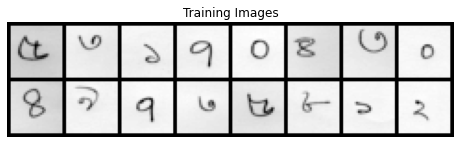

In [ ]:
start = time.time()
dataiter = iter(train_loader)
images,labels = dataiter.next()
print ('Time is {} sec'.format(time.time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

# Model Create & Summary

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2,inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Sigmoid()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)      # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        x = self.gen(x)
        return x;

summary(Generator(100).to(device), (100,))

class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.Sigmoid()
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        # retval = disc_pred.view(len(disc_pred), -1)
        return   disc_pred  # returns 1-dimension tensor representing fake/real


summary(Discriminator().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         230,656
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 830,785
Trainable params: 830,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Loss & Optimizer Initialization

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

netG = Generator(z_dim).to(device)
netD  = Discriminator().to(device)

# netG.apply(weights_init)
# netD.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0001)
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)

# noise = torch.randn(batch_size, z_dim, device=device)
# fake_img = netG(noise)
# unflat_img = fake_img.detach().cpu()
# img_grid = make_grid(unflat_img[0])
# plt.imshow(img_grid.permute(1, 2, 0).squeeze() , cmap='gray')


# Training Process

In [ ]:
def show_tensor_images(epoch, tensor_img, num_img=25, size=(1, 28, 28),nrow= 5):
    # tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], padding=2, normalize=True,nrow=nrow)
    plt.axis('off')
    plt.imshow(img_grid.permute(1, 2, 0).squeeze() , cmap='gray')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
epochs = 320
display_step = len(train_loader)
# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(256,epochs):
    # For each batch in the dataloader
    start = time.time()
    for i, data in enumerate(train_loader, 0):
        start_in = time.time()

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(0.)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(1.)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        print_val = f"[{epoch}/{epochs}][{i}/{len(train_loader)}]\t"
        print_val += f"Time_total : {time.time()-start}\t"
        print_val += f"Time_in : {time.time()-start_in}\t"
        print_val += f"Loss_D : {errD.item():.4f}\t"
        print_val += f"Loss_G : {errG.item():.4f}\t"
        print_val += f"D(x):: {D_x:.4f}\t"
        print_val += f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
        
        sys.stdout.write('\r' + str(print_val))

        # Output training stats
        if i % display_step == 0 and i != 0:
            print()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
    show_tensor_images(epoch , fake)
    # img_list.append(make_grid(fake, padding=2, normalize=True))

# Model Save

In [ ]:
from pathlib import Path
PATH = '/content/drive/MyDrive/Datasets/BengaliAI_Model/V1/'
Path(PATH).mkdir(parents=True, exist_ok=True)
PATH += 'model_netD_0_255.pth'
torch.save(netD.state_dict(), PATH)

PATH = '/content/drive/MyDrive/Datasets/BengaliAI_Model/V1/'
Path(PATH).mkdir(parents=True, exist_ok=True)
PATH += 'model_netG_0_255.pth'
torch.save(netG.state_dict(), PATH)

# After Tranning Visualization & Test

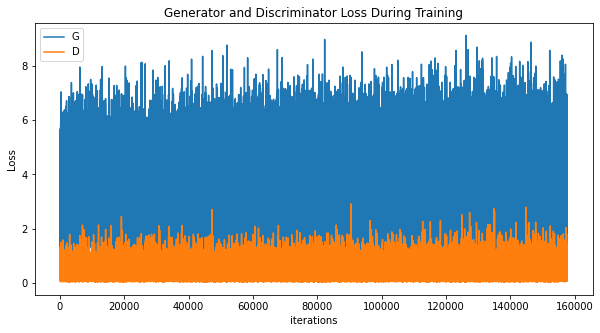

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

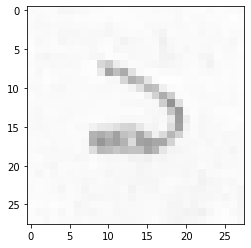

In [ ]:
def show_new_gen_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

num_image = 1
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = netG(noise)

show_new_gen_images(fake_img)